Author: Dominique Grimes

# Milestone 1: Data Selection & EDA

## Narrative

   Much of the work industry relies heavily on the productivity of their teammates. What does productivity really mean? Workplace productivity is an attempt at measuring how workplace teammates accomplish the production of quality goods and services in alignment with the organization’s strategic goals and objectives. The productivity of employees is essential to a company’s overall success in an ever-increasing completive market. Top organizations are looking for creative ways to do more with less resources, expense, time, and employee turnover. There are several internal and external factors that may impact an individual’s productivity. These items can vary from work or home environment, team culture, amount of time worked, if the person enjoys what they’re doing, if they are enrolled in school or have children, etc. Instead of focusing on productivity, as a unique spin I'd like to create a model that targets the amount of overtime worked. Overtime is very costly. I'd be interested to gain a better understanding of how overtime and productivity are correlated (either positively or negatively). For example, is the cost in overtime worth the incremental output of productivity gained? 

   The dataset I found is based on the clothing retail production industry, which is heavily dependent on human labor. Gaps in predicted production versus actual production can cause major issues in clothing supply and demand. Each row represents data based on daily metrics. The potential features of this model are: day of the week, the quarter of the month, department, team, number of workers on the team, number of style changes of the product, daily productivity goal, standard minute value (allocated time for a task), work in progress (number of unfinished items for products), amount of overtime (by each team in minutes), amount of financial incentive, and the amount of time production was interrupted. The target will be the overtime/worker.

## Data Cleansing

In [49]:
# Import libraries

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from fast_ml.model_development import train_valid_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# Load datasets into dataframe variables

data = pd.read_csv('train_dataset.csv')

In [3]:
# Vew data to verify that it loaded correctly.
data.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,department_finishing,department_finishing,department_sweing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity
0,9,0.75,3.94,NaN,960,0,0.0,0,0,8.0,...,1,0,0,0,0,0,0,0,1,0.755167
1,7,0.65,30.10,909.0,7080,0,0.0,0,1,59.0,...,0,0,1,0,0,0,1,0,0,0.535678
2,3,0.80,4.15,NaN,1440,0,0.0,0,0,7.0,...,0,1,0,0,0,0,0,0,1,0.820833
3,1,0.65,22.53,762.0,5040,0,0.0,0,1,42.0,...,0,0,1,0,0,0,0,0,1,0.581131
4,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,...,0,0,1,1,0,0,0,0,0,0.790003


In [4]:
# View the shape of the data
data.shape

(1017, 26)

In [5]:
# View columns
data.columns

# Note that there are two columns for department finishing, 
# department sweing is misspelled, and there is no day_Friday.

Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'month',
       'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing',
       'department_finishing ', 'department_sweing', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'actual_productivity'],
      dtype='object')

In [6]:
# Rename the department_sweing column header to department_sewing to correct the spelling.
data.rename(columns = {'department_sweing':'department_sewing'}, inplace=True)
data.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,department_finishing,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity
0,9,0.75,3.94,NaN,960,0,0.0,0,0,8.0,...,1,0,0,0,0,0,0,0,1,0.755167
1,7,0.65,30.10,909.0,7080,0,0.0,0,1,59.0,...,0,0,1,0,0,0,1,0,0,0.535678
2,3,0.80,4.15,NaN,1440,0,0.0,0,0,7.0,...,0,1,0,0,0,0,0,0,1,0.820833
3,1,0.65,22.53,762.0,5040,0,0.0,0,1,42.0,...,0,0,1,0,0,0,0,0,1,0.581131
4,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,...,0,0,1,1,0,0,0,0,0,0.790003


In [7]:
# Combine the two department_finishing department columns and 
# drop the second column with the space after the column header.
data['department_finishing'] = data['department_finishing']+data['department_finishing ']
data.drop(columns=['department_finishing '], inplace=True)
data.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,quarter_Quarter5,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity
0,9,0.75,3.94,NaN,960,0,0.0,0,0,8.0,...,0,1,0,0,0,0,0,0,1,0.755167
1,7,0.65,30.10,909.0,7080,0,0.0,0,1,59.0,...,0,0,1,0,0,0,1,0,0,0.535678
2,3,0.80,4.15,NaN,1440,0,0.0,0,0,7.0,...,0,1,0,0,0,0,0,0,1,0.820833
3,1,0.65,22.53,762.0,5040,0,0.0,0,1,42.0,...,0,0,1,0,0,0,0,0,1,0.581131
4,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,...,0,0,1,1,0,0,0,0,0,0.790003


## Graphical Analysis

### Correlation Heatmap

<function matplotlib.pyplot.show(close=None, block=None)>

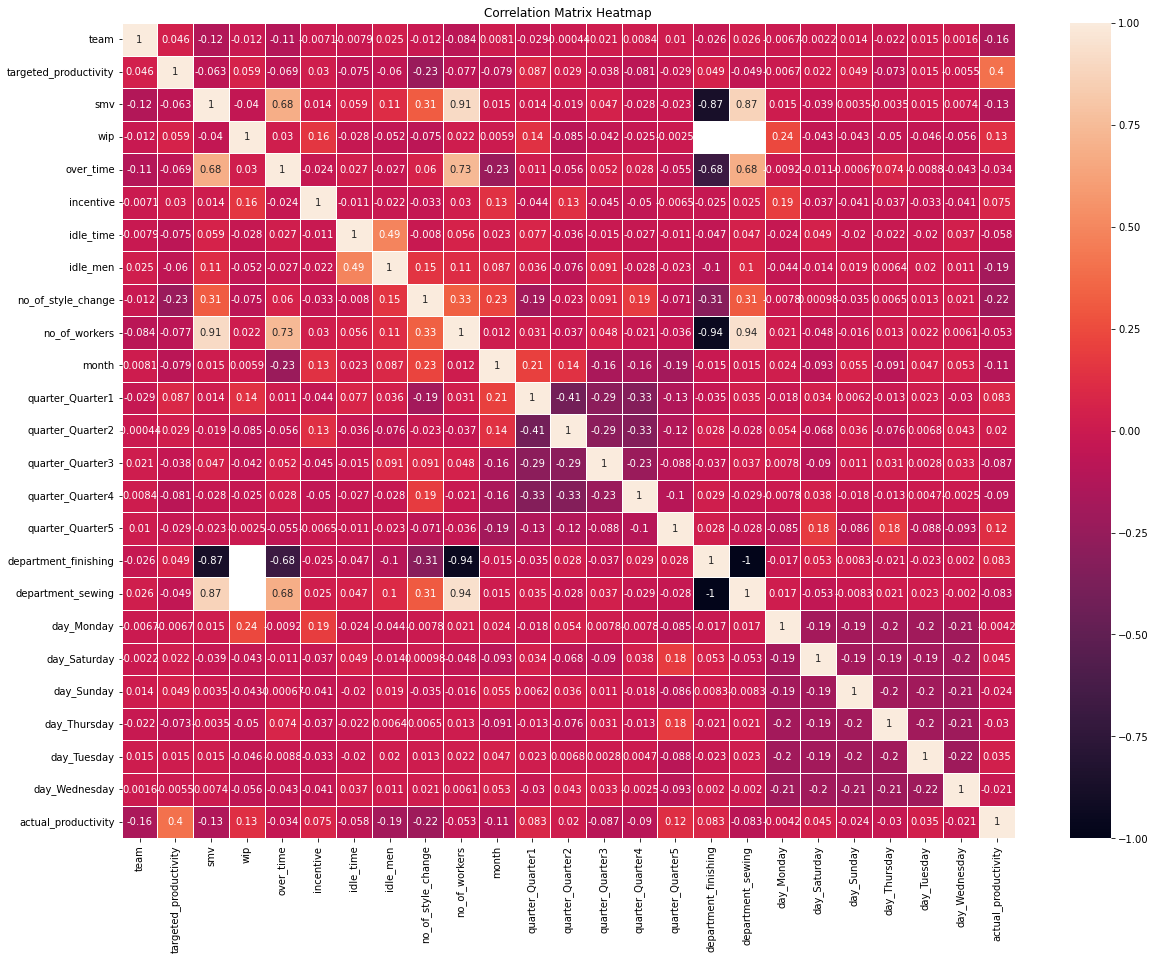

In [8]:
# Create a correlation matrix of data
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(20,15))

# Visualize the dataframe in a heatmap
sn.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)
plt.title('Correlation Matrix Heatmap')
plt.show

Looking specifically at positive correlations with overtime are deptartment_sewing (.68), no_of_workers (.73), and smv(.68). Some of the strongest correlations within the data are number_of_workers and department_sewing (.94), number_of_workers and smv (.91), and department_sewing and smv (.87).

### Scatter Plots

Let's take a look at the highest correlated variables with overtime. In addition, I'd like to also look at productivity and overtime.

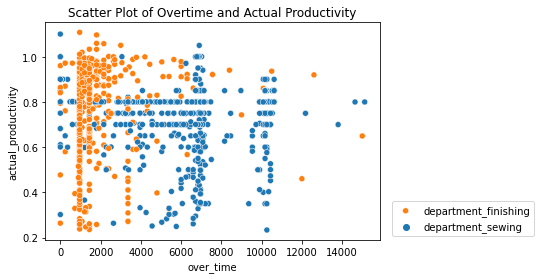

In [9]:
# Create Scatter Plot of Actual Productivity and Overtime
sn.scatterplot(data['over_time'], data['actual_productivity'], data=data, hue=data['department_finishing'])
plt.title('Scatter Plot of Overtime and Actual Productivity') # Add title
plt.legend(bbox_to_anchor=(1.02, 0.2), loc='upper left', labels=['department_finishing','department_sewing']) # Legend placement
plt.show()

# Clear warning
warnings.simplefilter(action='ignore', category=FutureWarning)

This plot shows overtime by productivity, categoized by department. From the coloring of the plot, it is clear that the finishing department (orange) has less overtime than the sewing department(blue). It does seem like the lower hours in overtime have generally higher concentrations in productivity. Whereas, the higher values of overtime has moderate productivity.

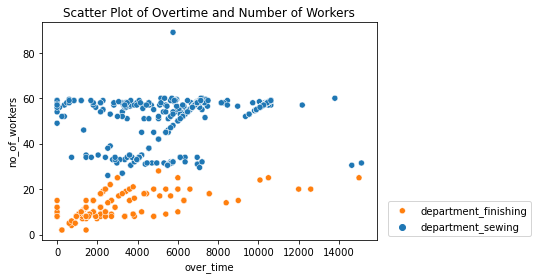

In [10]:
# Create Scatter Plot of number of workers and Overtime by department
sn.scatterplot(data['over_time'], data['no_of_workers'], data=data, hue=data['department_finishing'])
plt.title('Scatter Plot of Overtime and Number of Workers') # Add title
plt.legend(bbox_to_anchor=(1.02, 0.2), loc='upper left', labels=['department_finishing','department_sewing']) # Legend placement
plt.show()

This plot shows overtime by Number of Workers, categoized by department. From the coloring of the plot, it is clear that the finishing department (orange) has significantly less workers than the sewing department(blue). There are a few linear relationships emerging from the graphical analysis. I'm interested to view this scatter plot but by team instead of my department.

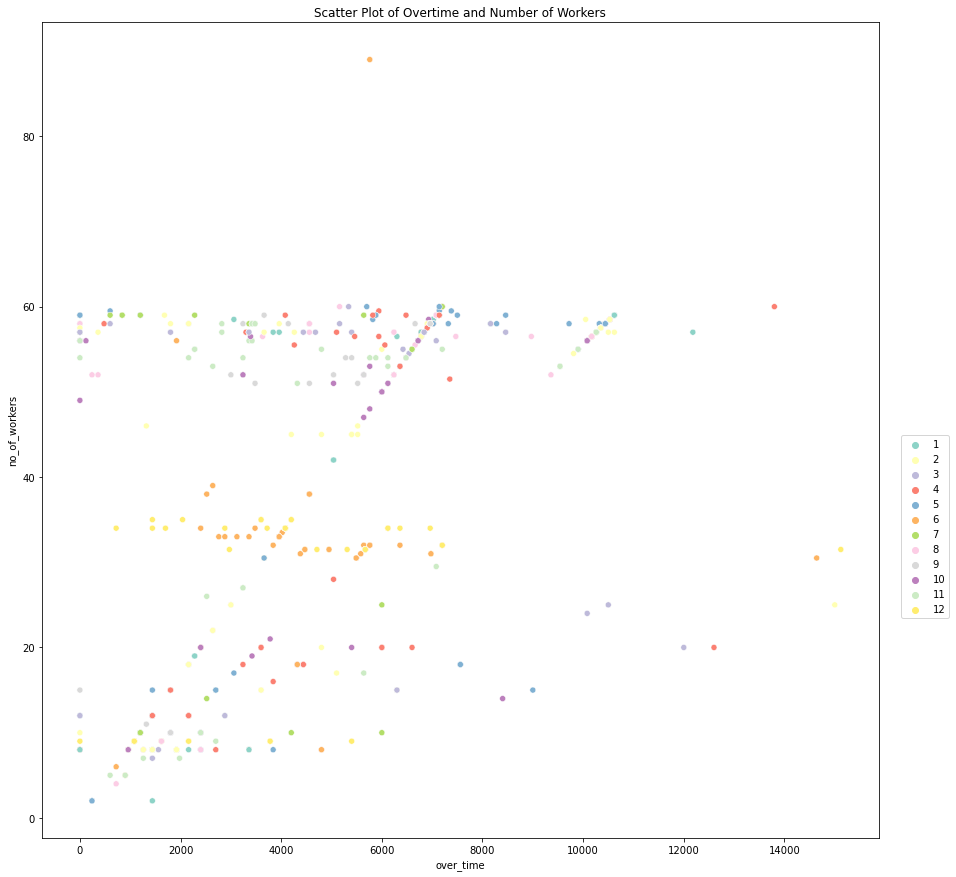

In [11]:
# Create Scatter Plot of number of workers and Overtime by team
fig, ax = plt.subplots(figsize=(15,15))
sn.scatterplot(data['over_time'], data['no_of_workers'], data=data, hue=data['team'], palette='Set3')
plt.title('Scatter Plot of Overtime and Number of Workers') # Add title
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='upper left') # Legend placement
plt.show()

No significant observations from this view. 

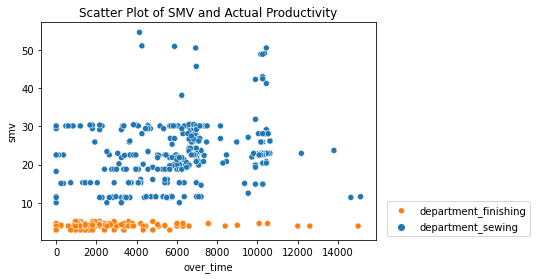

In [12]:
# Create Scatter Plot of SMV and Overtime
sn.scatterplot(data['over_time'], data['smv'], data=data, hue=data['department_finishing'])
plt.title('Scatter Plot of SMV and Actual Productivity') # Add title
plt.legend(bbox_to_anchor=(1.02, 0.2), loc='upper left', labels=['department_finishing','department_sewing']) # Legend placement
plt.show()

The finishing department has consistently low smvs with low variability The sewing department has much more variability with higher smvs.

Note: Instead of viewing the number of workers in a scatter plot. I'll view it in a bar plot next. 

### Bar Chart

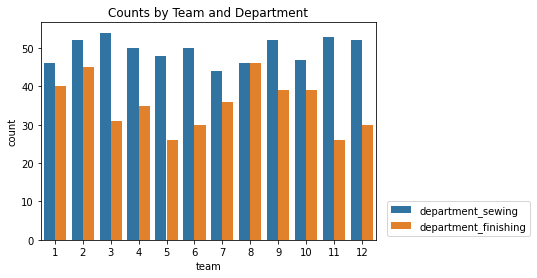

In [13]:
# Create a chart that counts the number of workers within each team by department.
sn.countplot(data=data, x="team", hue=data['department_finishing'])
plt.title('Counts by Team and Department')
plt.legend(bbox_to_anchor=(1.02, 0.2), loc='upper left', labels=['department_sewing','department_finishing']) # Legend placement
plt.show()

Each sewing team has relatively the same volume of workers with an approximate range of 5, while the finishing department has more variation in the total team counts (range of approximately 20 workers). The sewing department has higher counts than the finishing department overall.

## Overview of EDA

The graphical analysis shows a few features that are correlated with overtime. There are two departments and twelve teams. Overall, the finishing department has fewer teammates, lower smvs, less overtime, and higher productivity.

# Milestone 2: Data Preparation

## Manage missing data

In [14]:
# Set to None to display all rows in the dataframe
pd.set_option('display.max_columns', None)

In [15]:
# Calculating percentage of missing values in each column.
percent_missing = data.isnull().sum() * 100 / len(data)

# Create a data frame of the columns with their percent missing values.
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

# Show only columns with missing values over 0%.
missing_value_df = missing_value_df[missing_value_df.percent_missing>0]

# View columns with missing values.
missing_value_df

,column_name,percent_missing
wip,wip,41.59292


In [16]:
# Create a new data frame to view the wip and department_sweing
df = pd.read_csv('train_dataset.csv')
df_new = df[['wip','department_sweing']]
df_new[df_new['department_sweing']==0]

,wip,department_sweing
0,NaN,0
2,NaN,0
5,NaN,0
7,NaN,0
10,NaN,0
...,...,...
1000,NaN,0
1003,NaN,0
1004,NaN,0
1008,NaN,0


In [17]:
# In reviewing the 'wip' column's null values, it appears that the null values are all coming from the 
# finishing department. Since the missing values are not random and coming from one department only
# this can make the model bias. Other justificaion to drop this column is there are over 40% of the values
# missing. There is also very little correlation with the target variable.

# Drop 'wip' column
data.drop('wip', axis=1, inplace=True)

## Create dummy variables

In [18]:
# Identify data types of each column
data.dtypes

team                       int64
targeted_productivity    float64
smv                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
month                      int64
quarter_Quarter1           int64
quarter_Quarter2           int64
quarter_Quarter3           int64
quarter_Quarter4           int64
quarter_Quarter5           int64
department_finishing       int64
department_sewing          int64
day_Monday                 int64
day_Saturday               int64
day_Sunday                 int64
day_Thursday               int64
day_Tuesday                int64
day_Wednesday              int64
actual_productivity      float64
dtype: object

In [19]:
# Columns team and month need to be converted to categorical variables.
data['team'] = data.team.astype('category')
data['month'] = data.month.astype('category')

In [20]:
# Convert team & month into dummy variables, as these are categorical but represented as numbers in the raw data.
convert_dummy = data[['team','month']]
convert_dummy = pd.get_dummies(convert_dummy)
convert_dummy.head()

,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12,month_1,month_2,month_3
0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [21]:
# Join the data frame with the dummy columns with the train data frame and drop the old team & month columns.
data = data.join(convert_dummy).drop(['team','month'], axis=1)
data.head()

,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12,month_1,month_2,month_3
0,0.75,3.94,960,0,0.0,0,0,8.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0.755167,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0.65,30.10,7080,0,0.0,0,1,59.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0.535678,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0.80,4.15,1440,0,0.0,0,0,7.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0.820833,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.65,22.53,5040,0,0.0,0,1,42.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.581131,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.70,30.10,3300,50,0.0,0,1,57.0,0,1,0,0,0,0,1,1,0,0,0,0,0,0.790003,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## Create a new feature

In [22]:
# Create new column that calulcates over-time per no_of_workers.
data['over_time/no_of_workers'] = (data['over_time'] / data['no_of_workers'])

In [23]:
# View the data frame 
data.head()

,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,actual_productivity,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12,month_1,month_2,month_3,over_time/no_of_workers
0,0.75,3.94,960,0,0.0,0,0,8.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0.755167,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,120.000000
1,0.65,30.10,7080,0,0.0,0,1,59.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0.535678,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,120.000000
2,0.80,4.15,1440,0,0.0,0,0,7.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0.820833,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,205.714286
3,0.65,22.53,5040,0,0.0,0,1,42.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.581131,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,120.000000
4,0.70,30.10,3300,50,0.0,0,1,57.0,0,1,0,0,0,0,1,1,0,0,0,0,0,0.790003,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,57.894737


In [37]:
# Observe the number of columns
len(data.columns)

38

# Milestone 3: Model Building & Evaluation

In [24]:
# Create training, validation, and test set. Set target as over_time/no_of_workers.
# Split the data 80/10/10 using fast_ml train_valid_test_split
feature_train, target_train, feature_valid, target_valid, feature_test, target_test = train_valid_test_split(data, 
                                                                                                             target = 'over_time/no_of_workers', 
                                                                                                             train_size=0.8, 
                                                                                                             valid_size=0.10, 
                                                                                                             test_size=0.10)

## Scenario 1

The target is a continuous variable; therefore, classification models are not a good fit. The most familiar model for me for continuous distributions is a regression model. With several features included in the model one can assume a linear model will be extremely underfit. However, too many dimensions can cause overfitting. This scenario attempts fitting several polynomial regression models ranging from one to seven degrees. 

For preprocessing, the data needs to be scaled. I started with the most conservative scaler, the Min Max Scaler to oberseve the impact of scaling on the model. 

For feature selection, I used the thresholder method. I looked at both Variance Thresholder and PCA, and Variance Thresholder reduced more of the features. 

I am using r2 score and mse to evaluate the fit of each model. R2 is a great comparison tool when evaluating different regression models against each other, as it is measured independent of context. R2 shows the percentage of variability that the model accounts for. The mse can be used as a loss funtion and is sensitive to outliers. So we want to account for the maximum amount of variability and minimize the loss in our model performance.





In [43]:
# Doing a polynomial regression: Comparing linear, quadratic and cubic fits, upto degree 7

degrees = [1,2,3,4,5,6,7] 
mse = []
coeff = []
icpt = []
r2 = []

# Apply scalar to original training features
# Create scaler
mmscaler = MinMaxScaler()

# Scale feature
scaled_features_train = feature_train.copy()
scaled_features_train = mmscaler.fit_transform(scaled_features_train)

# Transform the validation features (DO NOT fit).
scaled_features_valid=mmscaler.transform(feature_valid)

# Find the scaled features in the training set that have a variance above 0.1.
thresholder = VarianceThreshold(threshold=.1)

# Create high variance feature matrix
thresholder_features_train = thresholder.fit_transform(scaled_features_train)

# Transform the validation features (DO NOT fit).
thresholder_features_valid=thresholder.transform(feature_valid)

# Fit a polynomial regression model for degrees 1 through 7
for degree in degrees:
    pipe = Pipeline([('poly_features', PolynomialFeatures(degree=degree)),('model', LinearRegression())])
    pipe.fit(thresholder_features_train, target_train)
    target_pred = pipe.predict(thresholder_features_valid) 
    r2.append(r2_score(target_valid, target_pred)) # Calculate r2 score and add to list
    mse.append(mean_squared_error(target_valid, target_pred, squared=False)) # Calculate mse and add to list
    coeff.append(pipe.steps[1][1].coef_) # Add Coefficient to list
    icpt.append(pipe.steps[1][1].intercept_) # Add intercept to list

In [44]:
# respective r-squared scores of predictions for each degree in the Polynomial regression
df_r2 = pd.DataFrame(np.column_stack([degrees, r2, mse]), columns=['Degree', 'r2', 'MSE'])
df_r2

,Degree,r2,MSE
0,1.0,0.138139,51.181228
1,2.0,-0.134849,58.730147
2,3.0,0.051886,53.681206
3,4.0,0.242687,47.976631
4,5.0,-0.004294,55.248761
5,6.0,-1.763686,91.650835
6,7.0,-8.521664,170.117301


## Scenario 2

For this scenario I used a standard scaler which is generally the industry go to for scaling. Regression models tend to benefit from normally distributed features, and standard scaler adjusts the mean to zero and creates a standard measure of variance.

In addition to polynomial regression, I chose to expand my model search to Ridge Regression as well as Lasso Regression with cross validation in lieu of feature selection/extraction methods such as Variance Thresholder and PCA. I chose apha values of .1, 1, 5 for cross validation.

In [27]:
# Create standard scaler
standscaler=StandardScaler()


# Create polynomial features
poly_features = PolynomialFeatures(include_bias=False)


# Create regression options and create a regressors list
lin_reg = LinearRegression() # This is needed for polynomial regression
ridge_reg = RidgeCV() 
lasso_reg = LassoCV()

regressors = [lin_reg, ridge_reg, lasso_reg] # list of regressors


# Expand the search space for degrees 1,2,3 and 4 for polynomial regression
# Also include ridge and lasso regressors with alpha values .1, 1.0, and 5.

search_space = [{"poly": [poly_features], "poly__degree": [1, 2, 3, 4]},
                {"regressor": [ridge_reg], "regressor__alphas": [0.1, 1.0, 5]},
                {"regressor": [lasso_reg], "regressor__alphas": [0.1, 1.0, 5]}]


# Fit a grid search with the pipeline, search space, 
# and 5-fold cross-validation to find the best values for the best model.

for regressor in regressors:
    pipeline = Pipeline(steps=[('scaler', standscaler),
                               ('poly', poly_features),
                               ('regressor', regressor)])
    regression = GridSearchCV(pipeline, search_space, cv=5, verbose=0, n_jobs=-1)

In [ ]:
# Fit grid search
best_model = regression.fit(feature_train, target_train)


# The follow convergence warning printed several times and the warnings could not be suppressed.
# Due to this, I cleared the output of the cell before printing.

#  model = cd_fast.enet_coordinate_descent(
#  /Users/dgrimes/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: 
#  ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, 
#  check the scale of the features or consider increasing regularisation. Duality gap: 6.773e+02, tolerance: 3.635e+02
#  model = cd_fast.enet_coordinate_descent(

In [29]:
# View best model and parameters
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('poly', PolynomialFeatures(include_bias=False)),
  ('regressor', LassoCV())],
 'verbose': False,
 'scaler': StandardScaler(),
 'poly': PolynomialFeatures(include_bias=False),
 'regressor': LassoCV(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'poly__degree': 2,
 'poly__include_bias': False,
 'poly__interaction_only': False,
 'poly__order': 'C',
 'regressor__alphas': None,
 'regressor__copy_X': True,
 'regressor__cv': None,
 'regressor__eps': 0.001,
 'regressor__fit_intercept': True,
 'regressor__max_iter': 1000,
 'regressor__n_alphas': 100,
 'regressor__n_jobs': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'regressor__precompute': 'auto',
 'regressor__random_state': None,
 'regressor__selection': 'cyclic',
 'regressor__tol': 0.0001,
 'regressor__verbose': False}

In [30]:
# Print the R2 and MSE of best fit model based on the hypertuning parameters in Senario 2.
lasso_r2 = r2_score(target_valid, best_model.predict(feature_valid))
lasso_mse = mean_squared_error(target_valid, best_model.predict(feature_valid), squared=False)

print('Lasso R2 Score:', lasso_r2)
print('Lasso Mean Squared Error:', lasso_mse)

Lasso R2 Score: 0.8991631789160215
Lasso Mean Squared Error: 17.506592863355074


## Overview/Conclusion

In Scenario 1 the polynomial regression model with the 4th degree had the highest r2 value of 0.24 with the lowest mse of 47.9. I'm confident that a better fitting model can be accomplished. If I were to repeat an second iteration of Scenario 1, I would fit the VaranceThresholder first before scaling. I would scale after feature selection since scaling the features and impacts the variance used in the feature selection process.

In Scenario 2, processing time is a challenge. Lasso and Ridge along with Grid Search Cross Validation are very time consuming. It took over 2 hours to fit the model and it produced convergence errors. I'd like to research further how to make adjustments to allow the model to converge more quickly. In lieu of trying both Ridge and Lasso, Elastic Net Regression could be used. I'd would also complete further iterations of hyperparameter tuning to the aplpha value. Overall, I am pleased with the higher r2 score of .90 and the reduced mse of 17.5 over Scenario 1.

# Milestone 4: Finalize

In [34]:
# Reevaluate the model on test data
lasso_r2_test = r2_score(target_test, best_model.predict(feature_test))
lasso_mse_test = mean_squared_error(target_test, best_model.predict(feature_test), squared=False)

print('Lasso R2 Score:', lasso_r2_test)
print('Lasso Mean Squared Error:', lasso_mse_test)

Lasso R2 Score: 0.9371046156687319
Lasso Mean Squared Error: 18.867033375141613


The model performed well on the test data with and increased r2 score and consistent rmse when comapared to the validation scores.

In [38]:
# View the number of features in the model
best_model.best_estimator_.n_features_in_

37

In [39]:
# No features were eliminated in fitting the LassoCV model

# View the features in the model
best_model.best_estimator_.feature_names_in_

array(['targeted_productivity', 'smv', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing',
       'department_sewing', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday',
       'actual_productivity', 'team_1', 'team_2', 'team_3', 'team_4',
       'team_5', 'team_6', 'team_7', 'team_8', 'team_9', 'team_10',
       'team_11', 'team_12', 'month_1', 'month_2', 'month_3'],
      dtype=object)